In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image
image = cv2.imread('Shapes/row_30.png', cv2.IMREAD_GRAYSCALE)

# Apply Gaussian Blur to smooth the image
blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

# Threshold the image to get a binary image
_, thresholded = cv2.threshold(blurred_image, 127, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Function to approximate contours
def approximate_contours(contours, epsilon_factor=0.01):
    approx_contours = []
    for contour in contours:
        epsilon = epsilon_factor * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        approx_contours.append(approx)
    return approx_contours

# Approximate the contours
approx_contours = approximate_contours(contours)

In [11]:
# Function to detect arcs in the approximated contours
def detect_arcs(contours, min_arc_length=50, circularity_threshold=0.7):
    arcs = []
    for contour in contours:
        for i in range(len(contour)):
            for j in range(i + 2, len(contour)):
                segment = contour[i:j]
                if len(segment) < 5:  # Not enough points to fit an ellipse
                    continue
                
                (x, y), (MA, ma), angle = cv2.fitEllipse(segment)
                ellipse_aspect_ratio = min(MA, ma) / max(MA, ma)
                
                if 0.5 < ellipse_aspect_ratio < 1.0:  # Roughly circular
                    arc_length = cv2.arcLength(segment, False)
                    if arc_length > min_arc_length:
                        circularity = (4 * np.pi * cv2.contourArea(segment)) / (arc_length ** 2)
                        if circularity > circularity_threshold:
                            arcs.append(segment)
    return arcs

# Detect arcs
arcs = detect_arcs(approx_contours)


In [12]:
def calculate_tangents(arc):
    # Fit a circle to the arc
    (x, y), radius = cv2.minEnclosingCircle(arc)
    center = (int(x), int(y))

    # Get the endpoints of the arc
    pt1 = tuple(arc[0][0])
    pt2 = tuple(arc[-1][0])

    # Calculate the tangents
    def tangent_point(pt):
        vec = np.array(pt) - np.array(center)
        tangent_vec = np.array([-vec[1], vec[0]])
        tangent_vec = tangent_vec / np.linalg.norm(tangent_vec) * radius
        tangent_pt = tuple((np.array(center) + tangent_vec).astype(int))
        return tangent_pt

    tangent1 = tangent_point(pt1)
    tangent2 = tangent_point(pt2)

    return (pt1, tangent1), (pt2, tangent2)

# Calculate tangents for all arcs
tangents = []
for arc in arcs:
    tangents.extend(calculate_tangents(arc))


In [13]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        return None  # Lines don't intersect

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

# Find intersections
intersection_points = []
for i in range(0, len(tangents), 2):
    if i + 1 < len(tangents):
        intersect_point = line_intersection(tangents[i], tangents[i + 1])
        if intersect_point:
            intersection_points.append(intersect_point)


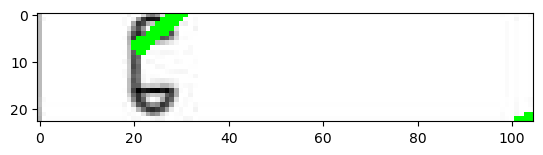

In [14]:
# Draw detected arcs
output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Draw tangents and intersection points
for line in tangents:
    cv2.line(output_image, line[0], line[1], (0, 255, 0), 2)

for point in intersection_points:
    cv2.circle(output_image, (int(point[0]), int(point[1])), 5, (0, 0, 255), -1)

# Display the result
plt.imshow(output_image)

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image
image = cv2.imread('Shapes/row_30.png', cv2.IMREAD_GRAYSCALE)

# Apply Gaussian Blur to smooth the image
blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

# Threshold the image to get a binary image
_, thresholded = cv2.threshold(blurred_image, 127, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(thresholded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


In [23]:
def estimate_curvature(contour, k=5):
    curvature = []
    for i in range(len(contour)):
        # Get k neighbors on either side
        p1 = contour[i - k][0] if i - k >= 0 else contour[0][0]
        p2 = contour[i][0]
        p3 = contour[(i + k) % len(contour)][0]

        # Calculate the curvature using the circle fitting method
        area = 0.5 * abs(p1[0]*p2[1] + p2[0]*p3[1] + p3[0]*p1[1] - p1[1]*p2[0] - p2[1]*p3[0] - p3[1]*p1[0])
        side_a = np.linalg.norm(p1 - p2)
        side_b = np.linalg.norm(p2 - p3)
        side_c = np.linalg.norm(p3 - p1)
        if side_a * side_b * side_c == 0:
            curvature.append(0)
        else:
            radius = (side_a * side_b * side_c) / (4 * area)
            curvature.append(1 / radius)

    return np.array(curvature)

# Estimate curvature for all contours
curvature_list = []
for contour in contours:
    curvature = estimate_curvature(contour)
    curvature_list.append(curvature)


In [24]:
def identify_bends(curvature, threshold=0.01):
    bends = []
    for i in range(len(curvature)):
        if curvature[i] > threshold:
            bends.append(i)
    return bends

# Identify bends for all contours
bends_list = []
for curvature in curvature_list:
    bends = identify_bends(curvature)
    bends_list.append(bends)


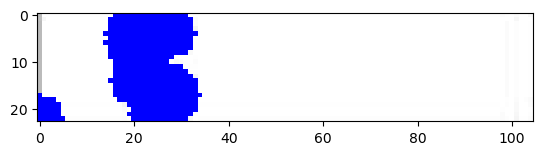

In [28]:
# Convert the image to color to draw colored points
output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Draw the bends on the image
for contour, bends in zip(contours, bends_list):
    for bend in bends:
        point = tuple(contour[bend][0])
        cv2.circle(output_image, point, 5, (0, 0, 255), -1)

# Display the result
plt.imshow(output_image)

### Preprocessing the image

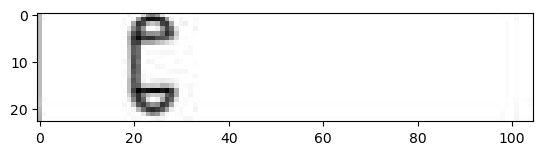

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image
image_path = "Shapes/row_30.png"

# Load the image
img = cv2.imread(image_path)

plt.imshow(img)


Total No. of bends: 24


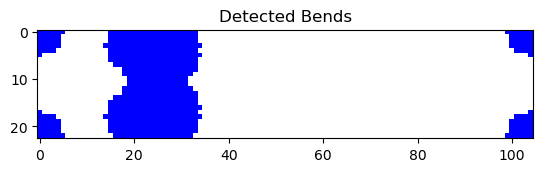

In [25]:
# Grayscale Image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur
blurred_img = cv2.GaussianBlur(gray, (1, 1), 0)

# canny image
canny_image = cv2.Canny(blurred_img, 90, 80)

# Dilation kernel and iterations
dilation_kernel = np.ones((1, 1), np.uint8)
dilation_iterations = 10 # Number of dilation iterations

dilated_img = cv2.dilate(blurred_img, dilation_kernel, dilation_iterations)

# Thresholding
_, thresh = cv2.threshold(dilated_img, 150, 255, cv2.THRESH_BINARY)

# Find Contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

def estimate_curvature(contour, k=5):
    """Estimates curvature of a contour using circle fitting method."""
    curvature = []
    for i in range(len(contour)):
        p1 = contour[i - k][0] if i - k >= 0 else contour[0][0]
        p2 = contour[i][0]
        p3 = contour[(i + k) % len(contour)][0]
        area = 0.5 * abs(
            (p1[0] * p2[1] + p2[0] * p3[1] + p3[0] * p1[1])
            - (p1[1] * p2[0] + p2[1] * p3[0] + p3[1] * p1[0])
        )
        side_a, side_b, side_c = (
            np.linalg.norm(p1 - p2),
            np.linalg.norm(p2 - p3),
            np.linalg.norm(p3 - p1),
        )
        radius = (side_a * side_b * side_c) / (4 * area) if area != 0 else 0
        curvature.append(1 / radius if radius != 0 else 0)
    return np.array(curvature)

def identify_bends(curvature, threshold=0.01):
    """Identifies bends in a curvature array based on a threshold."""
    return [i for i, val in enumerate(curvature) if val > threshold]

# Process Contours and Display Results
total_bends = 0
output_image = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)

for contour in contours:
    if len(contour) > 5:  # Filter out small contours
        curvature = estimate_curvature(contour)
        curvature = np.convolve(curvature, np.ones(5)/5, mode='same')  # Smooth curvature
        bends = identify_bends(curvature)

        for bend in bends:
            point = tuple(contour[bend][0])
            cv2.circle(output_image, point, 5, (0, 0, 255), -1)  # Red circles

        total_bends += len(bends)

        # # Display bend count for each contour
        # print(f"No. of bends in this contour: {len(bends)}")
        #
        # # Plot curvature for each contour
        # plt.figure()
        # plt.plot(curvature)
        # plt.title("Curvature Plot")
        # plt.xlabel("Point Index")
        # plt.ylabel("Curvature")
        # plt.show()

# Display total bend count and final image
print(f"\nTotal No. of bends: {total_bends}")
plt.figure()
plt.imshow(output_image)
plt.title("Detected Bends")
plt.show()


C:\Users\KIIT\AppData\Local\Temp\ipykernel_13916\1954467782.py:42: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


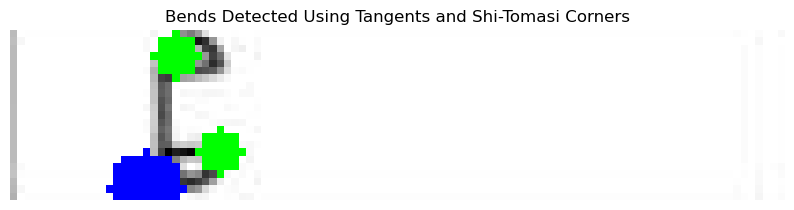


Total No. of bends: 1


In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image
img = cv2.imread('Shapes/row_30.png')

# Grayscale Image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Canny Edge Detection
canny = cv2.Canny(blurred, 100, 200)

# Dilation
kernel = np.ones((5, 5), np.uint8)
dilated = cv2.dilate(canny, kernel, iterations=1)

# Find Contours
contours, _ = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

def find_tangent_intersection(contour, start_idx, end_idx):
    """Finds intersection of tangents drawn from start and end points of a contour segment."""
    p1 = contour[start_idx][0]
    p2 = contour[end_idx][0]
    v1 = contour[(start_idx + 5) % len(contour)][0] - p1
    v2 = contour[(end_idx - 5) % len(contour)][0] - p2

    # Solve for intersection using line equations
    A = np.array([v1, -v2]).T
    b = np.array([p2 - p1]).T
    try:
        x = np.linalg.solve(A, b)
        intersection = p1 + x[0] * v1
        return intersection.astype(int)
    except np.linalg.LinAlgError:
        return None

corners = cv2.goodFeaturesToTrack(gray, maxCorners=100, qualityLevel=0.01, minDistance=10)
corners = np.int0(corners)

bend_points = []
for i in range(len(contours)):
    contour = contours[i]
    if len(contour) < 10:
        continue  # Skip small contours
    for j in range(0, len(contour) - 10, 10):  # Step through contour
        intersection = find_tangent_intersection(contour, j, j + 10)
        if intersection is not None:
            bend_points.append(intersection)

# Draw bends on the image
output_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for corner in corners:
    x, y = corner.ravel()
    cv2.circle(output_image, (x, y), 3, (0, 255, 0), -1)
for point in bend_points:
    x, y = point
    cv2.circle(output_image, (x, y), 5, (0, 0, 255), -1)

# Display the output image
plt.figure(figsize=(10, 6))
plt.imshow(output_image)
plt.title('Bends Detected Using Tangents and Shi-Tomasi Corners')
plt.axis('off')
plt.show()

print(f"\nTotal No. of bends: {len(bend_points)}")
